<a href="https://colab.research.google.com/github/Spica08/Deep-Learning-from-Scratch/blob/main/6%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pickle
from tqdm import tqdm
from collections import OrderedDict

In [2]:
#function

#恒等関数
def identity_function(x):
    return x

#ステップ関数
def step_function(x):
  y = x > 0
  return y.astype(int)

#シグモイド関数
def sigmoid(x):
  return 1/(1+np.exp(-x))

#ReLU関数
def ReLU(x):
  return np.maximum(0,x)

#ソフトマックス関数
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

#2乗和誤差
def mean_square_error(y, t):
  return 0.5 * np.sum((y-t)**2)

#交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す
        it.iternext()

    return grad

In [34]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis = 0)
    return dx

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None #softmaxの出力
    self.t = None #教師データ

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size
    return dx

In [36]:
class MultiLayerNet:
    """全結合による多層ニューラルネットワーク

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

# 学習に関するテクニック


## 6.1 パラメータの更新
ニューラルネットワーク目的は、損失関数の値をできるだけ小さくするパラメータを見つけること(最適化)。一方で、探索空間は非常に広大で最適解を見つけるのは難しい。  
ここまでで、パラメータの勾配を手がかりに最適なパラメータを求めようとしていた。これを確率的勾配降下法(SGD, stochastic gradient descent)という。ここでは別の最適化手法について学んでいく。

### 6.1.1 冒険家の話
略

### 6.1.2 SGD
SGDは以下の数式で書くことができる。  
$W \leftarrow W - η\frac{\partial L}{\partial W}$  


In [3]:
# SGDの実装
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 6.1.3 SGDの欠点
SGDは単純で実装も簡単だが、問題によっては非効率な場合がある。以下の関数の最小値を考える。  
$ f(x, y) = \frac{1}{20} x ^ 2 + y ^ 2$  
この関数はお椀をx軸方向に伸ばした形状をしている関数である。この関数の勾配を確認すると、y軸方向に大きな傾斜を持つ一方、x軸方向にはわずかな傾斜しか持たない。従って、最小値は(x, y) = (0, 0)であるにもかかわらず多くの場所で(0, 0) の方向を指さない。  
SGDの欠点は、関数の形状が等方的でないと非効率な経路で探索する点にある。

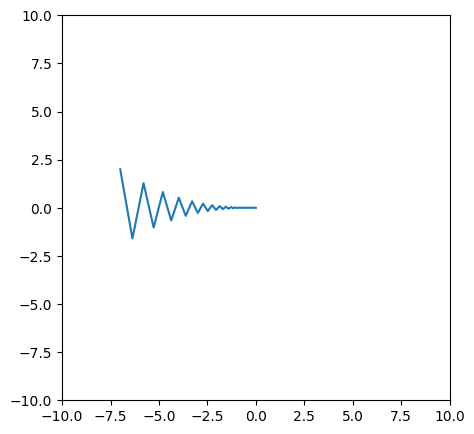

In [4]:
x = [-7]
y = [2]
for _ in range(100):
    nx = x[-1] - 0.9 * (1 / 10) * x[-1]
    ny = y[-1] - 0.9 * (2 * y[-1])
    x.append(nx)
    y.append(ny)
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(x, y)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show(fig)

### 6.1.4 Momemtum
モーメンタムとは、「運動量」という意味の言葉である。この手法は以下のように表される。  
$v \leftarrow αv - η\frac{\partial L}{\partial W}$  
$W \leftarrow W + v$  
新たなvというパラメータは、物理で言うところの「速度」に対応する。上式では、物体が勾配方向に力を受けその力によって物体の速度が加算されると言う物理法則を表している。αは、物体が何も力を受けない時に徐々に減速するための役割を担い、通常0.9などの値が設定される。

In [5]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        else:
            for key in params.keys():
                self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
                params[key] += self.v[key]

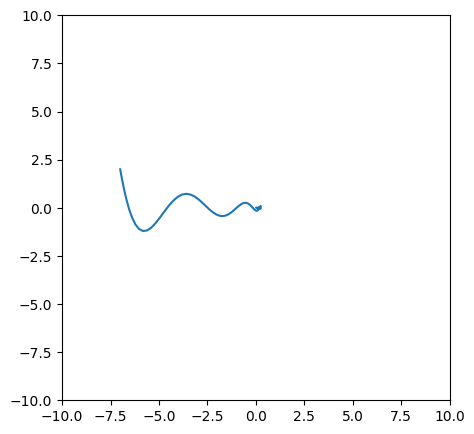

In [6]:
x = [-7]
y = [2]
vx = 0
vy = 0
for _ in range(100):
    vx = 0.9 * vx - 0.05 * (1 / 10) * x[-1]
    vy = 0.9 * vy - 0.05 * (2 * y[-1])
    nx = x[-1] + vx
    ny = y[-1] + vy
    x.append(nx)
    y.append(ny)
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(x, y)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show(fig)

### 6.1.5 AdaGrad
ニューラルネットワークの学習では適切な学習率の設定が重要である。この学習率に関する適切なテクニックに**学習係数の減衰**がある。これは学習が進むにつれて学習率を小さくする手法である。これを発展させたのがAdaGradである。これは「1つ1つのパラメータ」に対してオーダーメイドの値を与える。更新方法は以下の式で表される。  
$h \leftarrow h + \frac{\partial L}{\partial W} \bigodot \frac{\partial L}{\partial W}$  
$W \leftarrow W - η\frac{1}{\sqrt h}\frac{\partial L}{\partial W}$  
パラメータhはこれまで経験した勾配の値を2乗和として保存したもの。更新の際に$\frac{1}{\sqrt h}$を乗算することでスケールを調整する。これにより、より大きく動いたパラメータの学習率は次第に小さくなる。

In [7]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key in params.keys():
                self.h[key] = np.zeros_like(params[key])
        for key in params.leys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))

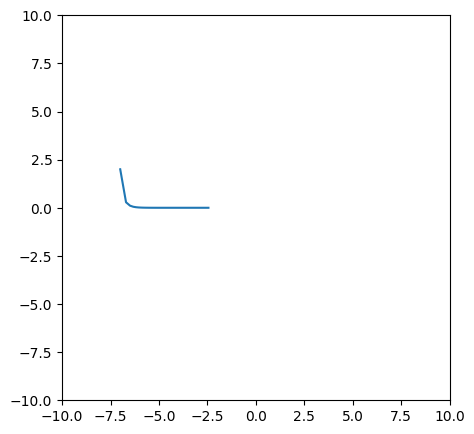

In [8]:
x = [-7]
y = [2]
hx = 0
hy = 0
for _ in range(100):
    hx += (1 / 10) * x[-1] * (1 / 10) * x[-1]
    hy += (2 * y[-1]) * (2 * y[-1])
    nx = x[-1] - 0.3 * (1 / 10) * x[-1] / (math.sqrt(hx) + 1e-7)
    ny = y[-1] - 0.3 * 2 * y[-1] / (math.sqrt(hx) + 1e-7)
    x.append(nx)
    y.append(ny)
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(x, y)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show(fig)

### 6.1.6 Adam
MomemtumとAdaGradを組み合わせた手法がAdamのベースとなっている。

In [9]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### 6.1.7 どの更新手法を用いるか
どの手法が最適かは、解くべき問題やパラメータによって変化する。

# 6.1.8 MNISTデータセットによる更新手法の比較
略


## 6.2 重みの初期値
ニューラルネットワークの学習では、重みの初期値がかなり重要になる。

### 6.2.1 重みの初期値を0にする？
過学習を抑え汎用性能を高めるテクニックとしてWeight decayがある。これは、重みパラメータの値が小さくなるように学習を行うことを目的とした手法である。  
重みを小さい値にするには、初期値もできるだけ小さい値から始めるのが直感的である。  
ここで、重みの値の初期値を0にすることを思いつくが、これは悪手である。実際にうまくいかない。理由は、誤差逆伝播法において全ての重みの値が同じように更新されてしまうからである。これにより重みが均一になってしまう。これを防ぐには、ランダムな初期値が必要であることがわかる。

# 6.2.2 隠れ層のアクティベーション分布
隠れ層のアクティベーションの分布を観察することで多くの知見を得ることができる。ここでは、重みの初期値によって隠れ層のアクティベーションがどのように変化するかを見てみることとする。

In [10]:
x = np.random.randn(1000, 100)

node_num = 100 # num of nodes
hidden_layer_size = 5 # num of hidden layers
activations = {} # store the result of activation

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) * 1

    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

5つの層があり、それぞれの層が100個のニューロンを持つものと仮定している。各層のアクティベーションの結果をactivationsに保存している。ここで、重みのスケールは標準偏差1のガウス分布を用いている。この分布を変更することでアクティベーションの分布がどのように変化するかを観察することが今回の実験の目的である。

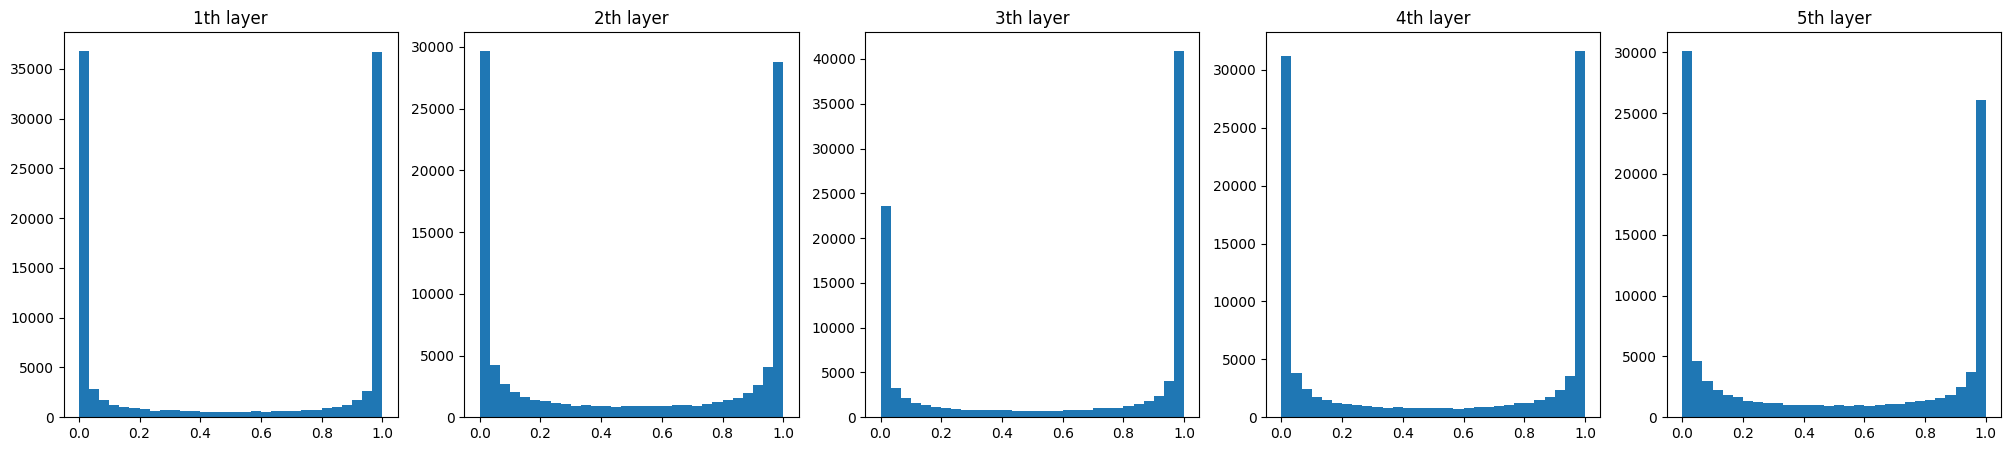

In [12]:
fig, axes = plt.subplots(figsize = (25, 5), ncols = 5)
for i, a in activations.items():
    axes[i].hist(a.flatten(), bins = 30, range = (0, 1))
    axes[i].set_title(f"{i + 1}th layer")
plt.show(fig)

各層のアクティベーションが0と1に偏った分布をしていることがわかる。ここで使用しているシグモイド関数は、その出力が0または1に近づくにつれて微分係数が0に近づく。そのため、0と1に偏ったデータ分布では、逆伝播における勾配の値がどんどん小さくなって消えてしまう。これを**勾配消失**と呼ぶ。  
続いて、重みの標準偏差を0.01として同じ実験を行う。

In [26]:
x = np.random.randn(1000, 100)

node_num = 100 # num of nodes
hidden_layer_size = 5 # num of hidden layers
activations = {} # store the result of activation

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) * 0.01

    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

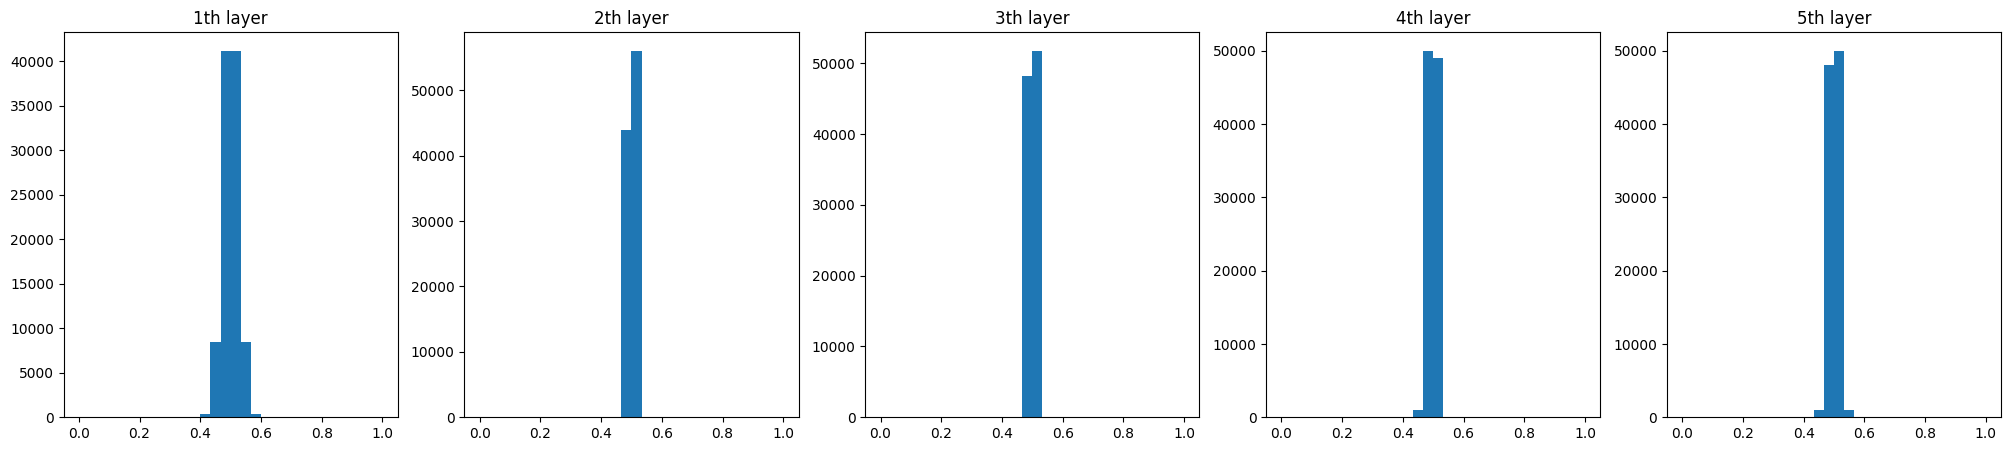

In [27]:
fig, axes = plt.subplots(figsize = (25, 5), ncols = 5)
for i, a in activations.items():
    axes[i].hist(a.flatten(), bins = 30, range = (0, 1))
    axes[i].set_title(f"{i + 1}th layer")
plt.show(fig)

この場合では0.5付近に集中する結果となった。先ほどとは違い勾配消失の問題は起こらないが、表現力という点で問題がある。各層のアクティベーションの分布は適度な広がりを持つことが重要となる。  
続いて「Xavier」の初期値を使ってみる。これは、「前層のノード数をnとした時、$\frac{1}{\sqrt n}$の標準偏差をもつ分布を使う」というもの。

In [13]:
x = np.random.randn(1000, 100)

node_num = 100 # num of nodes
hidden_layer_size = 5 # num of hidden layers
activations = {} # store the result of activation

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

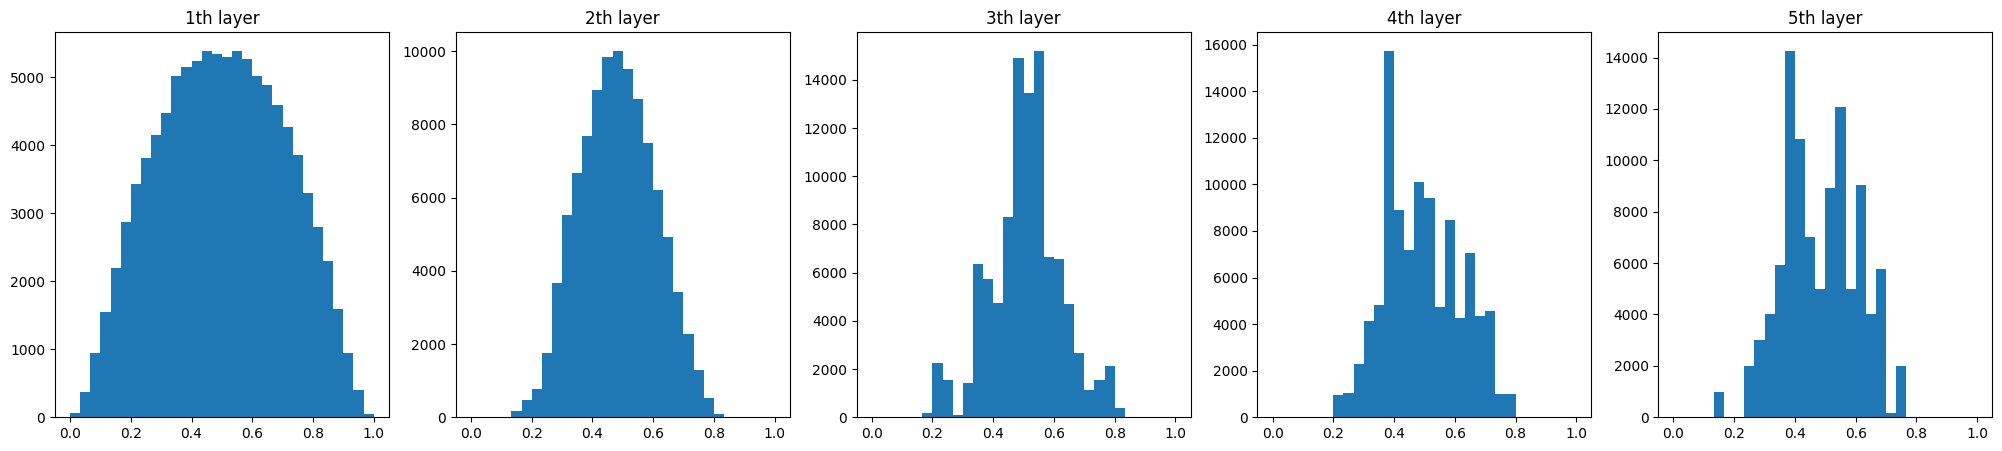

In [14]:
fig, axes = plt.subplots(figsize = (25, 5), ncols = 5)
for i, a in activations.items():
    axes[i].hist(a.flatten(), bins = 30, range = (0, 1))
    axes[i].set_title(f"{i + 1}th layer")
plt.show(fig)

これまでよりも広がりを持った分布になっていることが確認できた。

### 6.2.3 ReLUの重みの初期値
「Xaviernの初期値」は活性化関数が線形であることを前提に導いた結果であるため、ReLUを活性化関数として用いる際はより特化した初期値を用いることが推奨されている。ここでは「Heの初期値f」について考える。これは、前層のノード数をnとした時、$\sqrt \frac{2}{n}$を標準偏差とするガウス分布を用いるというもの。

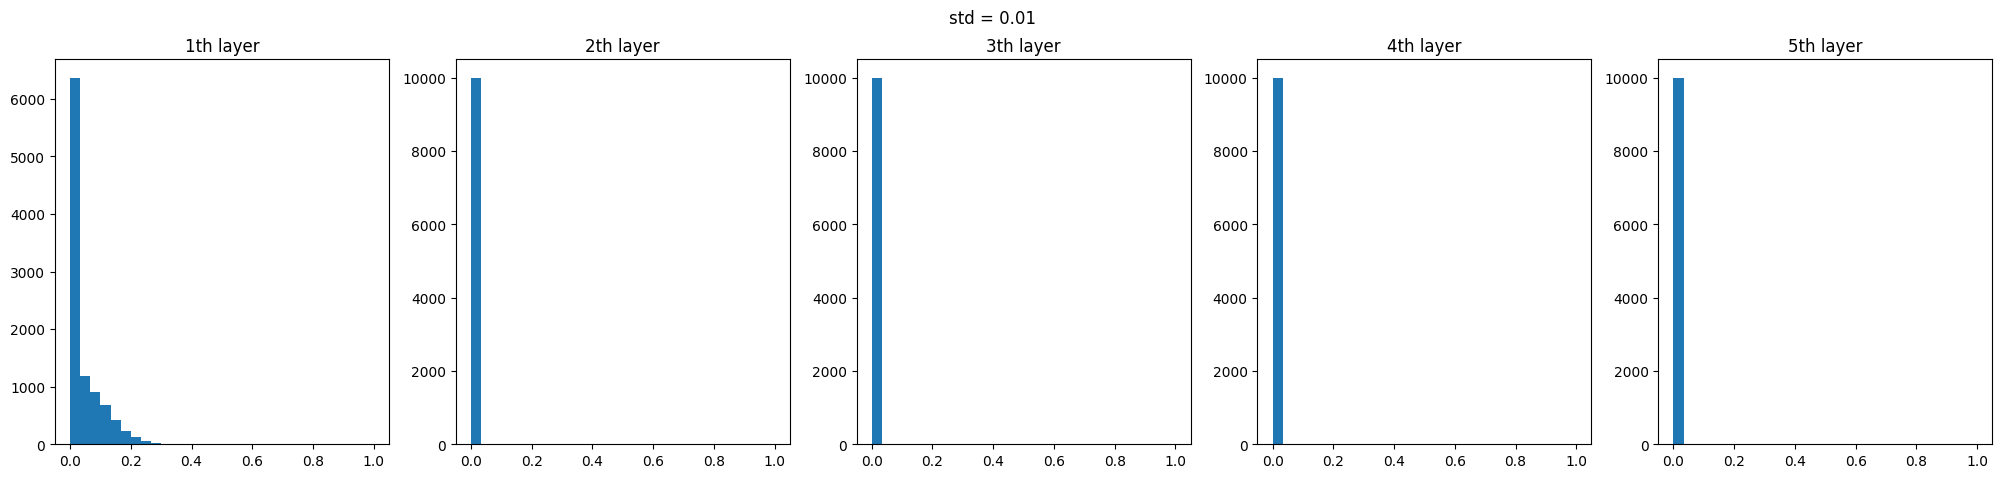

In [23]:
x = np.random.randn(100, 100)

node_num = 100 # num of nodes
hidden_layer_size = 5 # num of hidden layers
activations = {} # store the result of activation

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) * 0.01

    z = np.dot(x, w)
    a = ReLU(z)
    activations[i] = a
fig, axes = plt.subplots(figsize = (25, 5), ncols = 5)
for i, a in activations.items():
    axes[i].hist(a.flatten(), bins = 30, range = (0, 1))
    axes[i].set_title(f"{i + 1}th layer")
plt.suptitle("std = 0.01")
plt.show(fig)

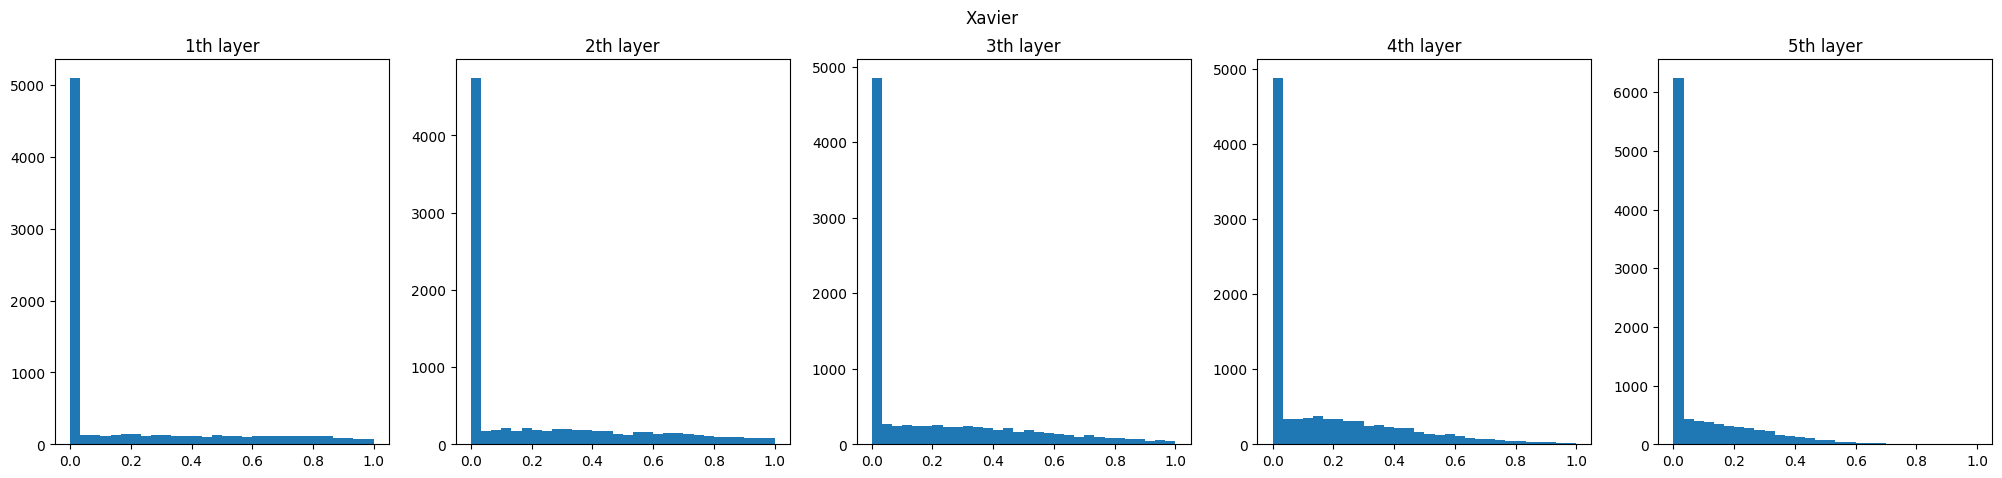

In [24]:
x = np.random.randn(100, 100)

node_num = 100 # num of nodes
hidden_layer_size = 5 # num of hidden layers
activations = {} # store the result of activation

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    z = np.dot(x, w)
    a = ReLU(z)
    activations[i] = a
fig, axes = plt.subplots(figsize = (25, 5), ncols = 5)
for i, a in activations.items():
    axes[i].hist(a.flatten(), bins = 30, range = (0, 1))
    axes[i].set_title(f"{i + 1}th layer")
plt.suptitle("Xavier")
plt.show(fig)

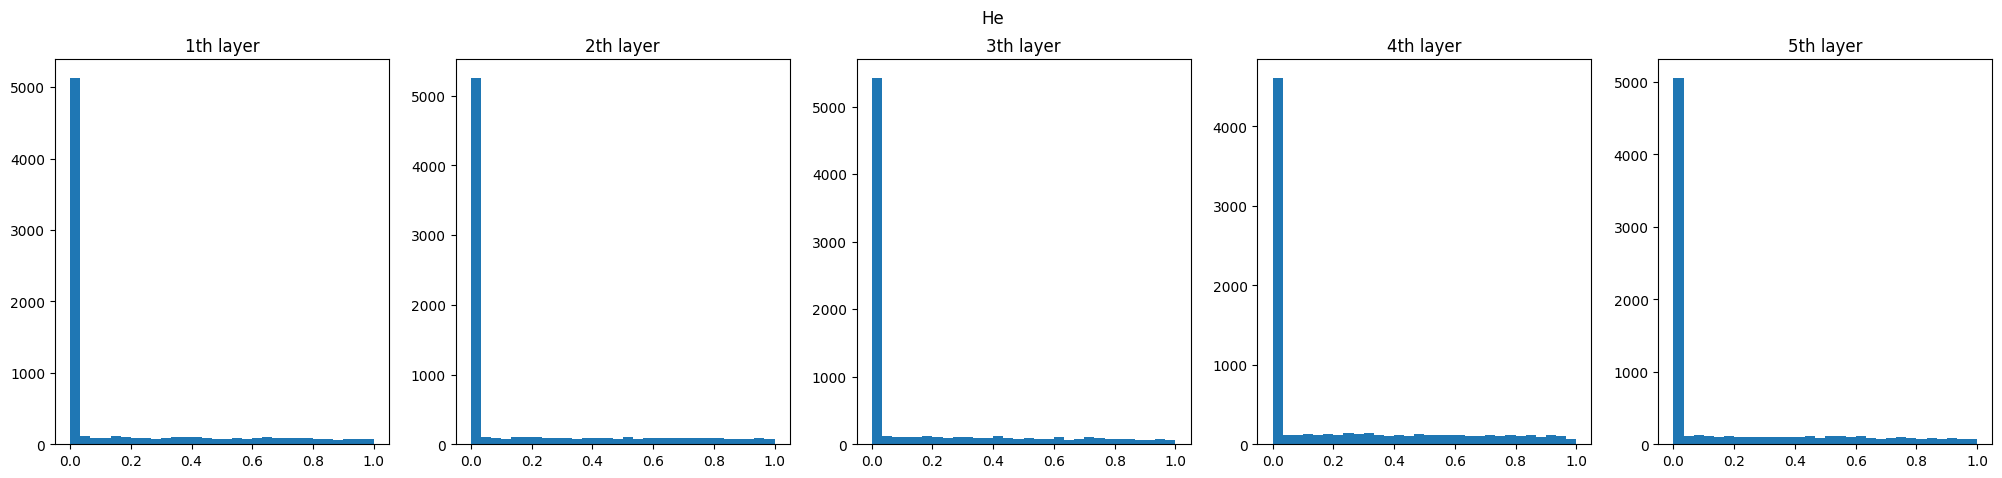

In [25]:
x = np.random.randn(100, 100)

node_num = 100 # num of nodes
hidden_layer_size = 5 # num of hidden layers
activations = {} # store the result of activation

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) * np.sqrt(2) / np.sqrt(node_num)

    z = np.dot(x, w)
    a = ReLU(z)
    activations[i] = a
fig, axes = plt.subplots(figsize = (25, 5), ncols = 5)
for i, a in activations.items():
    axes[i].hist(a.flatten(), bins = 30, range = (0, 1))
    axes[i].set_title(f"{i + 1}th layer")
plt.suptitle("He")
plt.show(fig)

Heの初期値が最も均一な分布となった。

### 6.2.4 MNISTデータセットによる重み初期値の比較
略

## 6.3 Batch Normalization
重みの初期値を適切に設定すれば各層のアクティベーションの分布は適度な広がりを持ち学習がスムーズになることがわかった。ここで、各層で適度な広がりを持つように強制的にアクティベーションの分布を調整するというアイデアをベースとする手法がBatch Normalization である。

### 6.3.1 Batch Normalizationのアルゴリズム
Batch Normalizationには次の性質がある。  
1. 学習を早く進行させることができる。
2. 初期値にそれほど依存しない
3. 過学習を抑制する  
Batch Normalizationでは、ニューラルネットワークにBatch Normalization レイヤーと呼ばれる、データの正規化を行うレイヤーを挿入する。  
Batch Normalizationでは、ミニバッチごとに正規化を行う。数式では以下のように表される。  
$μ_B \leftarrow \frac{1}{m}\sum_{n=1}^mx_i$  
$\sigma^2_B \leftarrow \frac{1}{m}\sum_{n=1}^m(x_i - μ_B)^2$  
$\hat{x_i} \leftarrow \frac{x_i - μ_B}{\sqrt{\sigma^2_B + \epsilon}}$  
これによりミニバッチの入力データは平均0分散1のデータへと変換される。  
さらに、Batch Normレイヤは、この正規化されたデータに対して固有のスケールとシフトで変換を行う。  
$y_i \leftarrow \gamma\hat{x_i} + \beta$  


### 6.3.2 Batch Normalization の評価
詳細略。Batch Normalizationを使用した方が、使用していない時の比べてほとんどのケースで学習が早く進み、ロバストになることが確認できた。

## 6.4 正則化
機械学習において、過学習が問題になることが多くある。

### 6.4.1 過学習
過学習が起きる原因としては主に以下の2つが挙げられる。
1. パラメータを大量に持ち、表現力の高いモデルであること
2. 訓練データが少ないこと
ここではわざとこれらの要件を満たして過学習を発生させてみる。

In [26]:
#データ準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# mnist.pyをインポート
import sys, os
sys.path.append("/content/drive/MyDrive/Colab Notebooks/ゼロから作るDeep Learning")
from mnist import load_mnist

In [29]:
#データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = True, one_hot_label = True)

#過学習のため学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

In [39]:
network = MultiLayerNet(input_size = 784, hidden_size_list = [100, 100, 100, 100, 100, 100], output_size = 10)
optimizer = SGD(lr = 0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt > max_epochs:break

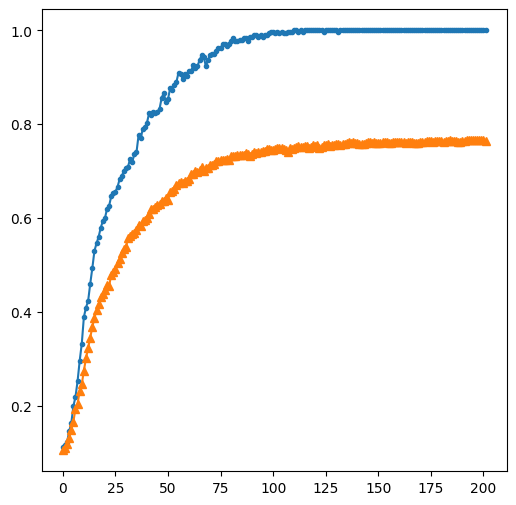

In [42]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(list(range(len(train_acc_list))), train_acc_list, marker = ".")
ax.plot(list(range(len(test_acc_list))), test_acc_list, marker = "^")
plt.show(fig)

テストデータにおいてうまく精度が出ていないことがわかる。

### 6.4.2 Weight decay
過学習抑制のために昔からよく用いられる手法に**Weight decay**がある。これは、学習の過程において大きな重みを持つことに対してペナルティを課すことで過学習を抑制しようとするものである。(そもそも過学習は重みパラメータが大きな値を取ることによって発生することがよくある)  
例えば、損失関数に対して重みの2乗ノルム(L2ノルム)を加算することを考えると、重みが大きくなることを抑えることができそうである。  


In [43]:
network = MultiLayerNet(input_size = 784, hidden_size_list = [100, 100, 100, 100, 100, 100], output_size = 10, weight_decay_lambda=0.1)
optimizer = SGD(lr = 0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt > max_epochs:break

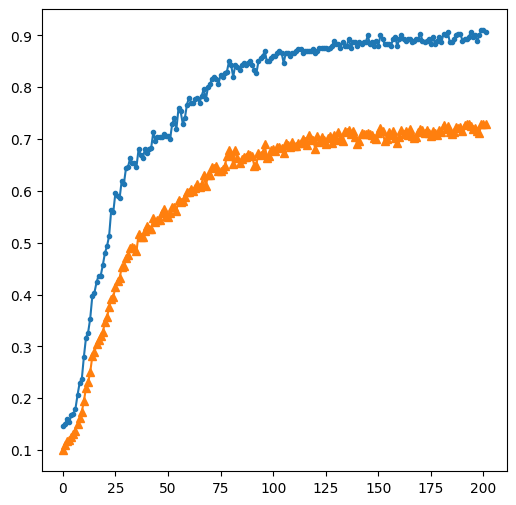

In [44]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(list(range(len(train_acc_list))), train_acc_list, marker = ".")
ax.plot(list(range(len(test_acc_list))), test_acc_list, marker = "^")
plt.show(fig)

先ほどよりもマシになった。

### 6.4.3 Dropout
ニューラルネットワークのモデルが複雑になってくると、Weighte decayだけでは対応が困難になる。そこでDropoutという手法がよく用いられる。  
Dropoutは、ニューロンをランダムに消去しながら学習する手法。訓練時に隠れ層のニューロンをランダムに選び出し、選び出されたニューロンを消去する。テスト時には、全てのニューロンの信号を伝達するが、各ニューロンの出力に対して訓練時に消去した割合を乗算して出力する。

In [ ]:
class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_fig = True):
        if train_fig:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

## 6.5 ハイパーパラメータの検証
ニューラルネットワークでは、ニューロンの数やバッチサイズなどのハイパーパラメータが重要となる。これらは適切な値に設定しなければ性能の悪いモデルになってしまう。ここでは、できるだけ効率的にハイパーパラメータの値を探索する方法について学ぶ。

### 6.5.1 検証データ  
ハイパーパラメータを検証する際に注意する点は、テストデータを使って性能評価をしてはいけないということである。テストデータを使ってハイパーパラメータの性能を評価してしまうと、ハイパーパラメータの値がテストデータに対して対して過学習してしまうからである。そのため、ハイパーパラメータを調整する際には、専用のデータセット(検証データ, validation set)が必要になる。

### 6.5.2 ハイパーパラメータの最適化
ハイパーパラメータの最適化を行う上では、「良い値」が存在する範囲を徐々に絞り込んでいくことが重要である。そのために、最初は大まかに範囲を設定してその中からランダムにパラメータをサンプリングして評価を行う。その後、性能を確認しながら範囲を狭めていく。  
ニューラルネットワークにおいては、グリッドサーチよりもランダムサンプリングの方が効率が良いことが報告されている。  
そのほか、ベイス最適化を用いた最適化手法も存在する。

### 6.5.3 ハイパーパラメータ最適化の実装
略